### *Import Packages and Modules*
***

In [2]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import glob
import re
import matplotlib.pyplot as plt
import matplotlib
import warnings
from matplotlib import *
from netCDF4 import Dataset
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
from pylr2 import regress2
import itertools
import statsmodels.api as sm
import time
from operator import itemgetter
import csv
import statistics
from major_axis_regression import regress2
from parula import parula
# parula is a .py file that should be found in script that adds parula, the same colour scale as Cael uses to the data. 

In [3]:
parula_map = parula()

***
### *Import Data*


In [4]:
OCCA = np.load('../../data/OCCA_masked2obs/NA_BB_OCCA.npy') # imports data created from "OCCA_mask_to_sediment_data"

In [51]:
# lists which indexes are which variables
# t = 0
# z = 7
# lat = 2
# lon = 3
# Foc = 4
# Fic = 5
# Fsi = 6

In [6]:
# replace zeros in the dataset with nans (where the coordinates sampled were inside the model land/bathymetry)
OCCA2 = np.ones((8,1106))*np.nan
for i in np.arange(0,8,1):
    for j in np.arange(0,1106,1):
        if OCCA[i,j] > 0:
            OCCA2[i,j] = OCCA[i,j]

In [7]:
OCCA3 = OCCA2[:, ~np.isnan(OCCA2).any(axis=0)] # remove nans from the dataset

In [8]:
OCCA3.shape # this is the NGD

(8, 923)

------
### Define Function

In [9]:
def JG_BBCael(data,bbeta,data_no,bbeta_pair_no):
    import statsmodels.api as sm
    import numpy as np 

    # find random coordinate points for SO 

    index_number = np.random.randint(0, high=n, size=data_no)        
    
    #print('average in mask:', np.average(new_mask))
    # this average should be 1 == only areas with values are selected
    #print('(should be one or else something went wrong)')

    # use randomly selected coordinate points to select 10000 random values of Foc, Fic and Fsi 
    random_Foc = data[4, index_number]
    random_Fic = data[5, index_number]
    random_Fsi = data[6, index_number]
    random_depth = data[7, index_number]
    
    # create x and y
    y = np.log(random_Foc[:, np.newaxis]) + (bbeta[:, 0] * np.subtract(np.log(random_depth[:, np.newaxis]),np.log(1000)))
    x = np.log((random_Fic[:, np.newaxis]) + (bbeta[:, 1] * random_Fsi[:, np.newaxis]))

    # initialise variables for regression analysis
    r_squared = np.ones((bbeta_pair_no))*np.nan
    slope = np.ones((bbeta_pair_no))*np.nan
    intercept = np.ones((bbeta_pair_no))*np.nan
    
    # run regression
    for i in np.arange(0,bbeta_pair_no,1):
        r_squared[i], slope[i], intercept[i] = regress2(x[:,i], y[:,i], _method_type_2="major axis")

    # find value of maximum r2
    r_maximum = np.nanmax(r_squared)

    # find where r2 = this maximum within the array
    where_max = np.where(r_squared==r_maximum)

    # find b, beta, slope and intercept where r2 = maximum
    b_maxr = np.nanmean(bbeta[where_max, 0])
    beta_maxr = np.nanmean(bbeta[where_max, 1])
    slope_max = np.nanmean(slope[where_max])
    intercept_max = np.nanmean(intercept[where_max])

    return r_maximum, b_maxr, beta_maxr, slope_max, intercept_max


------
### Create the b and beta range

In [53]:
# then we create b and beta range to search for in each sample taken. 
# these are estimated from a small b and beta sample. 
# later we ensure that the data isn't skewed to one side of the distribution searched within b and beta. 

In [52]:
# define b and beta
b = numpy.arange(0, 1, 0.05)
beta = numpy.arange(0,  0.2, 0.005)

# define number of searches within b and beta (for histograms later)
b_bins = 1/0.05
beta_bins = 0.2/0.005

# this calculates the number of b/beta unique combinations
bbeta = np.array(list(itertools.product(b, beta)))
bbeta_pair_no = int((bbeta[:,1].shape)[0])
print(bbeta_pair_no)

800


***
### *Run Regression*


In [56]:
n = 923 # this is the number of samples taken each time (ideally the same as the size of the dataset)
resamples = 1000 # this is the number of bootstrap resamples

In [57]:
#here we initiate the variables
r_maximum = np.ones((resamples))*np.nan
b_maxr = np.ones((resamples))*np.nan
beta_maxr = np.ones((resamples))*np.nan
slope_max = np.ones((resamples))*np.nan
intercept_max = np.ones((resamples))*np.nan
random_Fic = np.ones((resamples,n))*np.nan
random_Foc = np.ones((resamples,n))*np.nan
random_Fsi = np.ones((resamples,n))*np.nan
random_depth = np.ones((resamples, n))*np.nan

In [58]:
# here we run through the function which finds the best fit of b and beta of the range given
# we do this as many times as given in the resamples (usually at least as many data points)

for i in np.arange(0,resamples,1):
    w = time.time()
    r_maximum[i], b_maxr[i], beta_maxr[i], slope_max[i], intercept_max[i] = \
    JG_BBCael(OCCA3,bbeta,n,bbeta_pair_no)
    if i == 1:
        w1 = time.time()
        print(i, ':   ', w1-w)
    if i == 100:
        w2=time.time()
        print(i, ':    ', w2-w1)
    if i == 500:
        w3=time.time()
        print(i, ':    ', w3-w2)
    if i == 999:
        w4=time.time()
        print(i, ':    ', w4-w3)

1 :    0.18703389167785645
100 :     18.593156337738037
500 :     81.13009595870972
999 :     168.55540704727173


-------
# Plot Histograms
here we're looking to make sure that the searches for b and beta don't fall at the edges of the search limits

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  11., 138.,
        471., 340.,  38.,   2.,   0.,   0.,   0.,   0.,   0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

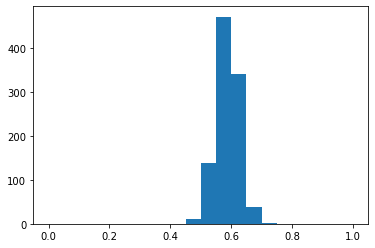

In [59]:
plt.hist(b_maxr, range=(0, 1), bins=int(b_bins))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   9.,  66., 163.,   0., 299.,
        246., 147.,  57.,  10.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.02  , 0.0245, 0.029 , 0.0335, 0.038 , 0.0425, 0.047 , 0.0515,
        0.056 , 0.0605, 0.065 , 0.0695, 0.074 , 0.0785, 0.083 , 0.0875,
        0.092 , 0.0965, 0.101 , 0.1055, 0.11  , 0.1145, 0.119 , 0.1235,
        0.128 , 0.1325, 0.137 , 0.1415, 0.146 , 0.1505, 0.155 , 0.1595,
        0.164 , 0.1685, 0.173 , 0.1775, 0.182 , 0.1865, 0.191 , 0.1955,
        0.2   ]),
 <BarContainer object of 40 artists>)

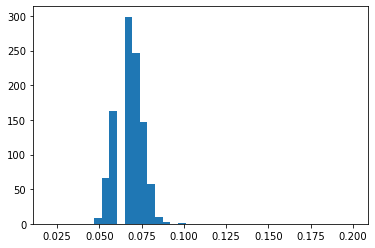

In [60]:
plt.hist(beta_maxr, range=(0.02, 0.2), bins=int(beta_bins))

-----
# Create median values for plotting graphs

In [61]:
# find median values of the best fit regressions

r_median = np.nanmedian(r_maximum)
b_median = np.nanmedian(b_maxr)
beta_median = np.nanmedian(beta_maxr)
intercept_median = np.nanmedian(intercept_max)
slope_median = np.nanmedian(slope_max)

# Calculate alpha(si) and alpha(ic) values from the median beta, intercept and slope values
where kappa = e^intercept and gamma = slope of the line

y = Foc(z/1000)

x = Fic * beta(Fsi))^gamma

and: beta is ~ to a_si/a_ic

### therefore:

if: y = k * (beta * x^gamma)

beta = alpha_si/alpha_ic

alpha_ic = kappa^(1/gamma)

alpha_si = beta * kappa^(1/gamma)

k(kappa) = e^(intercept) and gamma = slope

the equation becomes Foc = (alpha_ic Fic + alpha_si Fsi)^gamma (z/1000)^b. so beta = alpha_si/alpha_ic.




In [62]:
kappa = np.exp(intercept_max)
kappa_median = np.median(np.exp(intercept_max))

In [63]:
a_ic_1 = kappa**(1/slope_median)
a_si_1 = beta_median*kappa**(1/slope_median)

In [64]:
a_ic = kappa_median**(1/slope_median)
a_si = beta_median*kappa_median**(1/slope_median)

In [65]:
print(a_ic)
print(a_si)

21.536232145257973
1.3998550894417683


In [66]:
# find the standard deviation for all values
SD_r = round(statistics.stdev(r_maximum),4)
SD_b = round(statistics.stdev(b_maxr),3)
SD_aic = round(statistics.stdev(a_ic_1),3)
SD_asi = round(statistics.stdev(a_si_1),3)
SD_int = round(statistics.stdev(intercept_max),3)
SD_slope = round(statistics.stdev(slope_max),3)

# print medians and standard deviation of b, alpha_IC and alpha_Si
print('r2:        ', round(r_median, 2))
print('b:         ', round(b_median, 3))
print('a_ic:      ', round(a_ic, 2))
print('a_si:      ', round(a_si, 2))
print('intercept: ', round(intercept_median, 2))
print('kappa:     ', round(kappa_median, 2))
print('slope:     ', round(slope_median, 2))
print(SD_b, SD_aic, SD_asi)

r2:         0.87
b:          0.55
a_ic:       21.54
a_si:       1.4
intercept:  2.27
kappa:      9.72
slope:      0.74
0.039 1.227 0.08


-----
### Create values for plotting graphs

# create x, y and scale

In [67]:
log_y = np.log(OCCA3[4,:]) + (b_median * np.subtract(np.log(OCCA3[7,:]),np.log(1000)))
log_x = np.log((kappa_median**slope_median)*((OCCA3[5,:]) + (beta_median * OCCA3[6,:])))

y = np.exp(log_y)
x = np.exp(log_x)

scale = OCCA3[5,:] / OCCA3[6,:]

In [68]:
# create the data for plotting the line

x_line = [0.00001, np.max(x)+10000]
y_line = kappa_median*x_line**slope_median

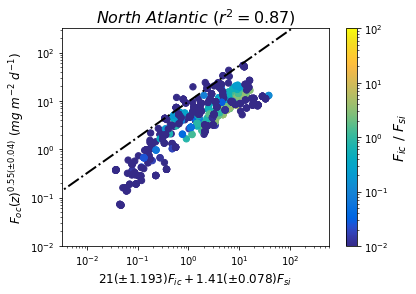

In [69]:
ax = plt.gca()
plt.plot(x_line, y_line, color='black', ls='-.', lw=2)
g = ax.scatter(x, y, c=scale, cmap=parula_map, norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=100), s=40)
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1e-2, 316.227766017)
plt.xlim(0.00316227766, 600)

cbar = plt.colorbar(g)

plt.title(r'$North \ Atlantic \ (r^{2} = 0.87)$', size=16)

plt.ylabel(r'$F_{oc}\left ({z}  \right )^{0.55 (\pm 0.04)} \ (mg \ m^{-2} \ d^{-1})$', size=12) 

plt.xlabel(r'$21 (\pm 1.193) F_{ic} + 1.41 (\pm 0.078) F_{si}$', size=12)

cbar.set_label(r'${F_{ic}} \ / \ {F_{si}}$', size=14)

plt.show()